In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline 

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
ntrain   = trainimg.shape[0]
ntest    = testimg.shape[0] 
dim      = trainimg.shape[1]
nclasses = trainlabel.shape[1]

# Recurrent neural network 
diminput  = 28
dimhidden = 128
dimoutput = nclasses
nsteps    = 28
weights = {
    'hidden': tf.Variable(tf.random_normal([diminput, dimhidden])), 
    'out': tf.Variable(tf.random_normal([dimhidden, dimoutput]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([dimhidden])),
    'out': tf.Variable(tf.random_normal([dimoutput]))
}
def _RNN(_X, _istate, _W, _b, _nsteps, _name):
    # 1. Permute input from [batchsize, nsteps, diminput] => [nsteps, batchsize, diminput]
    _X = tf.transpose(_X, [1, 0, 2])
    # 2. Reshape input to [nsteps*batchsize, diminput] 
    _X = tf.reshape(_X, [-1, diminput])
    # 3. Input layer => Hidden layer
    _H = tf.matmul(_X, _W['hidden']) + _b['hidden']
    # 4. Splite data to 'nsteps' chunks. An i-th chunck indicates i-th batch data 
    _Hsplit = tf.split(0, _nsteps, _H) 
    # 5. Get LSTM's final output (_O) and state (_S)
    #    Both _O and _S consist of 'batchsize' elements
    with tf.variable_scope(_name, reuse=None):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(dimhidden, forget_bias=1.0)
        _LSTM_O, _LSTM_S = tf.nn.rnn(lstm_cell, _Hsplit, initial_state=_istate)
    # 6. Output
    _O = tf.matmul(_LSTM_O[-1], _W['out']) + _b['out']    
    # Return! 
    return {
        'X': _X, 'H': _H, 'Hsplit': _Hsplit,
        'LSTM_O': _LSTM_O, 'LSTM_S': _LSTM_S, 'O': _O 
    }
print ("Network ready")

Network ready


In [4]:
learning_rate       = 0.001

x      = tf.placeholder("float", [None, diminput, nsteps])
y      = tf.placeholder("float", [None, dimoutput])
state  = tf.placeholder("float", [None, 2 * dimhidden])

lstm  = _RNN(x, state, weights, biases, nsteps, 'basic')
pred   = lstm['O']
cost   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) 
optm   = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
accr   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1), tf.argmax(y,1)), tf.float32))

print("done")

done


In [10]:
# Learning Parameters
batch_size          = 100
plot_step           = 1
display_step        = 1
training_epochs     = 5
total_loss = np.zeros(training_epochs, dtype=np.float32)

init   = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

print ("Started ..")
for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(num_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape((batch_size, nsteps, diminput))
        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, state: np.zeros((batch_size, 2*dimhidden))})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys 
                                              , state: np.zeros((batch_size, 2*dimhidden))})/num_batch
    # Display logs per epoch step
    if epoch % display_step == 0: 
        print ("Epoch: %03d/%03d cost: %.3f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, state: np.zeros((batch_size, 2*dimhidden))})
        print (" Training accuracy: %.3f" % (train_acc))
    total_loss[epoch] = avg_cost;
print (".. Finished.")

Started ..
Epoch: 000/005 cost: 0.495
 Training accuracy: 0.940
Epoch: 001/005 cost: 0.137
 Training accuracy: 0.950
Epoch: 002/005 cost: 0.087
 Training accuracy: 1.000
Epoch: 003/005 cost: 0.063
 Training accuracy: 0.970
Epoch: 004/005 cost: 0.050
 Training accuracy: 1.000
.. Finished.


Test accuracy of the network: 0.972


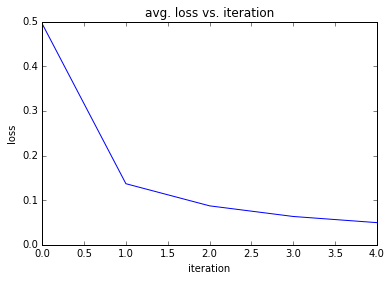

In [11]:
#plot chart
plt.figure(0)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.title("avg. loss vs. iteration")
plt.plot(total_loss)

testimg = testimg.reshape((ntest, nsteps, diminput))
test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel, state: np.zeros((ntest, 2*dimhidden))})
print ("Test accuracy of the network: %.3f" % (test_acc))

In [38]:
n_truncate = 28
n_cut = 20

print ("Started ...")
for i in range(n_cut):
    testimg = testimg.reshape((ntest, nsteps, diminput))
    testimg_truncated = np.zeros(testimg.shape)
    testimg_truncated[:, (nsteps - n_truncate):, :] = testimg[:, :n_truncate, :]

    test_acc = sess.run(accr, feed_dict={x: testimg_truncated, y: testlabel, state: np.zeros((ntest, 2*dimhidden))})
    print (" If we use %d seqs, test accuracy becomes %.3f" % (n_truncate, test_acc))
    n_truncate = n_truncate - 1

print ("Finished.")


Started ..
 If we use 28 seqs, test accuracy becomes 0.972
 If we use 27 seqs, test accuracy becomes 0.970
 If we use 26 seqs, test accuracy becomes 0.927
 If we use 25 seqs, test accuracy becomes 0.810
 If we use 24 seqs, test accuracy becomes 0.650
 If we use 23 seqs, test accuracy becomes 0.565
 If we use 22 seqs, test accuracy becomes 0.507
 If we use 21 seqs, test accuracy becomes 0.451
 If we use 20 seqs, test accuracy becomes 0.400
 If we use 19 seqs, test accuracy becomes 0.340
 If we use 18 seqs, test accuracy becomes 0.282
 If we use 17 seqs, test accuracy becomes 0.245
 If we use 16 seqs, test accuracy becomes 0.216
 If we use 15 seqs, test accuracy becomes 0.193
 If we use 14 seqs, test accuracy becomes 0.163
 If we use 13 seqs, test accuracy becomes 0.130
 If we use 12 seqs, test accuracy becomes 0.106
 If we use 11 seqs, test accuracy becomes 0.097
 If we use 10 seqs, test accuracy becomes 0.107
 If we use 9 seqs, test accuracy becomes 0.123
Finished ..
